The following model is the standard GAN which is part of **Exercise 1**. It is a very simple example and you can improve it by adding convolutions and many other ideas that we talked about if you want. Fill in the missing pieces and train it.


In [1]:
%matplotlib inline

import os
import numpy as np
import math
import multiprocessing
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.optim.optimizer import Optimizer, required
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs("images_gan", exist_ok=True)
os.makedirs("images_cgan", exist_ok=True)

n_epochs = 5                                  #number of epochs of training
batch_size = 128                               #size of the batches
lr = 0.0005                                    #adam: learning rate
b1 = 0.5                                       #adam: decay of first order momentum of gradient
b2 = 0.999                                     #adam: decay of second order momentum of gradient
n_cpu = multiprocessing.cpu_count()            #number of cpu threads to use during batch generation
latent_dim = 100                               #dimensionality of the latent space
img_size = 28                                  #size of each image dimension
channels = 1                                   #number of image channels
sample_interval = 400                          #interval between image samples


img_shape = (channels, img_size, img_size)
torch.manual_seed(42)

In [16]:
def to_onehot(digits, num_classes):
    """ [[3]] => [[0, 0, 1]]
    """
    labels_onehot = torch.zeros(digits.shape[0], num_classes).to(device)
    labels_onehot.scatter_(1, digits.view(-1, 1), 1)
    return labels_onehot

def plot_class_distributions(y_pred, num_classes):
    class_distributions = [np.sum(y_pred == i) for i in range(num_classes)]
    plt.bar(list(range(num_classes)), class_distributions, tick_label=list(range(num_classes)))
    plt.ylabel("Number of predictions")
    plt.xlabel("Class")
    plt.plot()
    
class GeneratorBlock(nn.Module):
    def __init__(self, in_feat, out_feat, activation, use_norm=True):
        super().__init__()
        self.dense = nn.Linear(in_feat, out_feat)
        self.activation = activation
        if use_norm:
            self.bn = nn.BatchNorm1d(out_feat, 0.8)
        else:
            self.bn = None
            
    def forward(self, x):
        x = self.dense(x)
        x = self.activation(x)
        if self.bn != None:
            x = self.bn(x)
        return x
        

class Generator(nn.Module):
    def __init__(self, num_classes=0):
        super().__init__()
        self.b1 = GeneratorBlock(latent_dim + num_classes, 128, activation=nn.LeakyReLU(0.2), use_norm=False)
        self.b2 = GeneratorBlock(128, 256, activation=nn.LeakyReLU(0.2))
        self.b3 = GeneratorBlock(256, 512, activation=nn.LeakyReLU(0.2))
        self.b4 = GeneratorBlock(512, 1024, activation=nn.LeakyReLU(0.2))
        self.b5 = GeneratorBlock(1024, 1 * 28 * 28, activation=nn.Tanh(), use_norm=False)

    def forward(self, x, y=None):
        if y != None:
            x =  torch.cat((x, y), dim=1)
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = x.view(-1, 1, 28, 28)
        return x


class Discriminator(nn.Module):
    def __init__(self, num_classes=0, use_sigmoid=True):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28 + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
        self.use_sigmoid = use_sigmoid

    def forward(self, x, y=None):
        x = x.view(x.shape[0], -1)
        if y != None:
            x =  torch.cat((x, y), dim=1)
        x = self.model(x)
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x

In [17]:
# Loss function
bce_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)
bce_loss.to(device)

# Configure data loader
os.makedirs("./mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset(
        [
            datasets.MNIST(
                "./mnist",
                train=True,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            ),
            datasets.MNIST(
                "./mnist",
                train=False,
                download=True,
                transform=transforms.Compose(
                    [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
                ),
            ),
        ]
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu
)
     
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [18]:
# ----------
#  Training
# ----------

def train_loop(generator, discriminator, dataloader, optimizer_g, optimizer_d, loss_func, num_epochs, with_labels, use_wasserstein):
    iterations = len(dataloader)
    gen_losses, disc_losses = [], [] 
    for epoch in range(num_epochs):
        running_gen_loss = 0.0
        running_disc_loss = 0.0
        for i, (real_imgs, y) in enumerate(dataloader):

            real_imgs =  real_imgs.to(device)
            if with_labels:
                y = to_onehot(y.to(device), 10)
            else:
                y = None

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            z = torch.randn((real_imgs.shape[0], latent_dim)).to(device)
            gen_imgs = generator(z, y)

            y_pred_fake = discriminator(gen_imgs)
                        
            if use_wasserstein:
                g_loss = loss_func(y_pred_fake)
            else:
                g_loss = loss_func(y_pred_fake, torch.zeros_like(y_pred_fake))
            g_loss.backward()
            optimizer_G.step()
 
            # ---------------------
            #  Train Discriminator
            # ---------------------

            gen_imgs = generator(z, y)

            y_pred_real = discriminator(real_imgs, y)
            y_pred_fake = discriminator(gen_imgs, y)

            optimizer_D.zero_grad()
            
            if use_wasserstein:
                real_loss = loss_func(y_pred_real)
                fake_loss = loss_func(y_pred_fake)
                d_loss = (real_loss - fake_loss) / 2
            else:
                real_loss = loss_func(y_pred_real, torch.zeros_like(y_pred_real))
                fake_loss = loss_func(y_pred_fake, torch.ones_like(y_pred_real))
                d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            running_gen_loss += g_loss.item()
            running_disc_loss += d_loss.item()

            batches_done = epoch * len(dataloader) + i
            if batches_done % sample_interval == 0:
                # You can also safe samples in your drive & maybe save your network as well
                save_image(gen_imgs.data[:25], "images_gan/GAN-%d.png" % batches_done, nrow=5, normalize=True)

        gen_loss = running_gen_loss / iterations
        disc_loss = running_disc_loss / iterations
        loss = gen_loss + disc_loss
        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)
        print(f"Epoch {epoch + 1}/{n_epochs} ==> loss: {loss}, gen_loss: {gen_loss}, disc_loss: {disc_loss}")
        grid = make_grid(gen_imgs.data[:25], nrow=5, normalize=True).cpu().numpy()
        # Channels first (PyTorch) to channels last (matplotlib)
        grid = np.moveaxis(grid, 0, -1)
        plt.imshow(grid, cmap='gray')
        plt.axis('off')
        plt.show()
    return gen_losses, disc_losses

Epoch 1/5 ==> loss: 1.4898569356970204, gen_loss: 0.8851084861448085, disc_loss: 0.6047484495522117


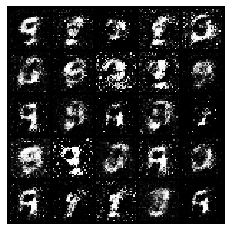

Epoch 2/5 ==> loss: 1.7735503799191776, gen_loss: 1.1972372580380937, disc_loss: 0.576313121881084


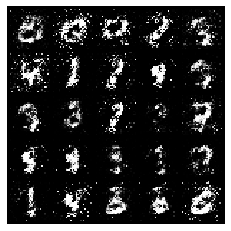

Epoch 3/5 ==> loss: 1.7907299915332027, gen_loss: 1.213751065774635, disc_loss: 0.5769789257585676


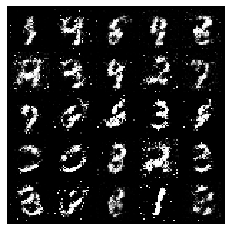

Epoch 4/5 ==> loss: 1.6685128898463693, gen_loss: 1.057360243099917, disc_loss: 0.6111526467464524


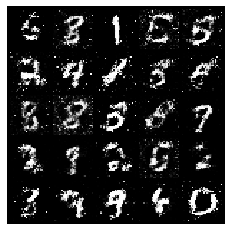

Epoch 5/5 ==> loss: 1.60222713363236, gen_loss: 0.9672455554470502, disc_loss: 0.6349815781853099


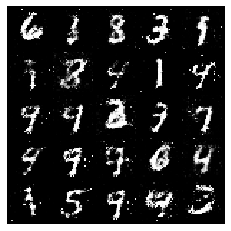

In [5]:
gen_losses, disc_losses = train_loop(
    generator, 
    discriminator,
    dataloader,
    optimizer_G,
    optimizer_D,
    bce_loss,
    n_epochs,
    False,
    use_wasserstein=False
)

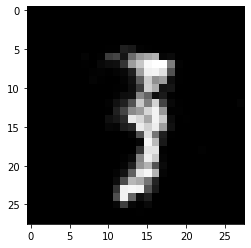

In [6]:
z = torch.randn((2, 100)).to(device)

# Generate a batch of images
with torch.no_grad():
    gen_imgs = generator(z, None)
    
plt.imshow(gen_imgs.cpu().numpy()[0].reshape((28, 28)), cmap='gray')

In [8]:
class Classifer(nn.Module):
    def __init__(self, in_dims):
        super().__init__()
        self.conv1 = nn.Conv2d(in_dims, 16, kernel_size=(3, 3), padding=1, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1, stride=2)
        self.dense1 = nn.Linear(4 * 4 * 64, 10)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = self.conv3(x)
        x = torch.nn.functional.relu(x)
        x = x.view(-1, 4 * 4 * 64)
        x = self.dense1(x)
        x = torch.softmax(x, dim=1)
        return x
    
clf = Classifer(1).to(device)

clf_optim = torch.optim.Adam(clf.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss().to(device)


for epoch in range(1, 5):
    running_loss = 0
    running_accuracy = 0
    iterations = 0
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        clf_optim.zero_grad()
        y_pred = clf(x)
        loss = criterion(y_pred, y)
        loss.backward()
        clf_optim.step()
        running_loss += loss.item()
        iterations += 1
        with torch.no_grad():
            accuracy = torch.mean(((torch.argmax(y_pred, 1) == y) * 1).float())
            running_accuracy += accuracy.item()
    loss = running_loss / iterations
    acc = running_accuracy / iterations
    print(f"Epoch {epoch}/4 ==> train loss: {loss}, train acc: {acc}")

Epoch 1/4 ==> train loss: 1.6661621412803747, train acc: 0.8018126470297302
Epoch 2/4 ==> train loss: 1.500080902136222, train acc: 0.9639857828726063
Epoch 3/4 ==> train loss: 1.486414010825497, train acc: 0.976346222966419
Epoch 4/4 ==> train loss: 1.4817296674090286, train acc: 0.9802718563533135


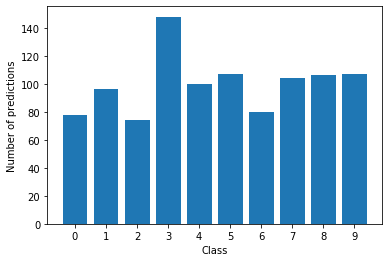

In [9]:
z = torch.randn((1000, latent_dim)).to(device)

# Generate a batch of images
with torch.no_grad():
    gen_imgs = generator(z)
    y_pred = clf(gen_imgs)
    
y_pred = np.argmax(y_pred.cpu().numpy(), axis=1)
plot_class_distributions(y_pred, 10)

# WGAN

Epoch 1/5 ==> loss: -0.07385502692986232, gen_loss: -0.036908339021192824, disc_loss: -0.03694668790866949


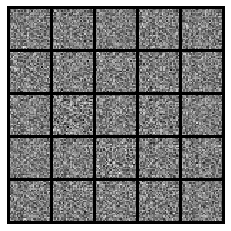

Epoch 2/5 ==> loss: -0.07385457700060534, gen_loss: -0.03690758832411967, disc_loss: -0.03694698867648567


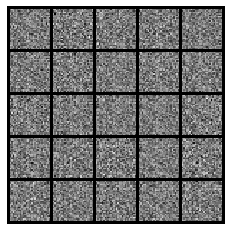

Epoch 3/5 ==> loss: -0.07385545248468789, gen_loss: -0.036907742021288686, disc_loss: -0.03694771046339921


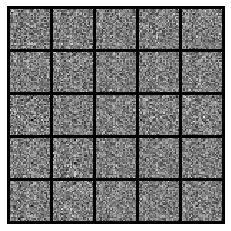

Epoch 4/5 ==> loss: -0.07385470340168018, gen_loss: -0.03690783469724917, disc_loss: -0.036946868704431014


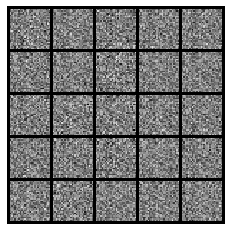

Epoch 5/5 ==> loss: -0.07385515501991705, gen_loss: -0.036908254047797844, disc_loss: -0.036946900972119195


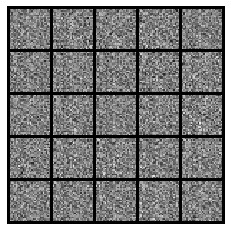

In [19]:
def wasserstein_loss(y_pred):
    return torch.mean(y_pred)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(b1, b2))

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator(0, use_sigmoid=False)

generator.to(device)
discriminator.to(device)
bce_loss.to(device)

gen_losses, disc_losses = train_loop(
    generator, 
    discriminator,
    dataloader,
    optimizer_G,
    optimizer_D,
    wasserstein_loss,
    n_epochs,
    False,
    use_wasserstein=True
)

# CGAN

In [ ]:
# Initialize generator and discriminator
generator = Generator(10)
discriminator = Discriminator(10)

generator.to(device)
discriminator.to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

gen_losses, disc_losses = train_loop(
    generator, 
    discriminator,
    dataloader,
    optimizer_G,
    optimizer_D,
    bce_loss,
    n_epochs,
    True,
    use_wasserstein=False
)

In [ ]:
z = torch.randn((1000, latent_dim)).to(device)

y = [i % 100 for i in range(1000)]

# Generate a batch of images
with torch.no_grad():
    y = torch.LongTensor([i % 10 for i in range(1000)]).to(device)
    y = to_onehot(y, 10)
    gen_imgs = generator(z, y)
    y_pred = clf(gen_imgs)
    
y_pred = np.argmax(y_pred.cpu().numpy(), axis=1)
plot_class_distributions(y_pred)

In [ ]:
for name, param in generator.named_parameters():
    print(name, param.shape)